# Alumno: Gerardo de Miguel González

## Minería de Datos (Master en Data Science, UIMP-UC)  2018-2019

## Profesores: Sixto Herrera y Rodrigo García

# T01 Variables Categóricas: Reglas de Asociación y Árboles de Clasificación

En la presente tarea consideraremos el dataset `Mushroom`, incluido tanto en la La librería [arulesViz](https://cran.r-project.org/web/packages/arulesViz/arulesViz.pdf) como en las diferentes plataformas descritas en el marco de la asignatura y en el GitHub dedicado a este Máster ([Mushroom](https://github.com/SantanderMetGroup/Master-Data-Science/blob/master/Data_mining/datasets/mushrooms.csv.)), para aplicar las diferentes técnicas vistas en el curso para variables categóricas: Reglas de Asociación y Árboles de Clasificación.

Para el desarrollo de la tarea se permitirá el uso de todo el material incluido en el Moodle de las asignatura así como el desarrollado por el alumno durante la realización de las prácticas.

La entrega consisitirá de un notebook de Jupyter ó un R-MarkDown, junto con el archivo html que éste genera. Ambos ficheros se entregarán a través del Moodle de la asignatura en la tarea correspondiente.

## ::GMG::Punto 0.

### Bibliotecas

In [1]:
#::GMG::El primer paso es cargar las bibliotecas necesarias pra hace la práctica
library(RCurl) #::GMG::Get remote dataset

Loading required package: bitops


### Carga de datos

In [2]:
#::GMG::También necesitamos el dataset
#       http://archive.ics.uci.edu/ml/datasets/Mushroom
# specify the URL for the Iris data CSV
urlfile <-'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
downloaded <- getURL(urlfile, ssl.verifypeer=FALSE)
connection <- textConnection(downloaded)
dataset <- read.csv(connection, header=FALSE)

### Exploración  y limpieza 

In [3]:
#::GMG::Vemos lo que hemos descargado
head(dataset)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23
p,x,s,n,t,p,f,c,n,k,⋯,s,w,w,p,w,o,p,k,s,u
e,x,s,y,t,a,f,c,b,k,⋯,s,w,w,p,w,o,p,n,n,g
e,b,s,w,t,l,f,c,b,n,⋯,s,w,w,p,w,o,p,n,n,m
p,x,y,w,t,p,f,c,n,n,⋯,s,w,w,p,w,o,p,k,s,u
e,x,s,g,f,n,f,w,b,k,⋯,s,w,w,p,w,o,e,n,a,g
e,x,y,y,t,a,f,c,b,n,⋯,s,w,w,p,w,o,p,k,n,g


In [4]:
#::GMG::Hay que poner nombres a las columnas
#::nota:: LEER
# http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
#::nota::no se pueden poner '-' en los nombres de las columnas en R por conflicto con operador "-"
names(dataset) = c('class','cap.shape','cap.surface','cap.color','bruises','odor',
                   'gill.attachment','gill.spacing','gill.size','gill.color','stalk.shape',
                   'stalk.root','stalk.surface.above.ring', 'stalk.surface.below.ring',
                   'stalk.color.above.ring','stalk.color.below.ring','veil.type',
                   'veil.color','ring.number','ring.type','spore.print.color',
                   'population','habitat')
head(dataset)

class,cap.shape,cap.surface,cap.color,bruises,odor,gill.attachment,gill.spacing,gill.size,gill.color,⋯,stalk.surface.below.ring,stalk.color.above.ring,stalk.color.below.ring,veil.type,veil.color,ring.number,ring.type,spore.print.color,population,habitat
p,x,s,n,t,p,f,c,n,k,⋯,s,w,w,p,w,o,p,k,s,u
e,x,s,y,t,a,f,c,b,k,⋯,s,w,w,p,w,o,p,n,n,g
e,b,s,w,t,l,f,c,b,n,⋯,s,w,w,p,w,o,p,n,n,m
p,x,y,w,t,p,f,c,n,n,⋯,s,w,w,p,w,o,p,k,s,u
e,x,s,g,f,n,f,w,b,k,⋯,s,w,w,p,w,o,e,n,a,g
e,x,y,y,t,a,f,c,b,n,⋯,s,w,w,p,w,o,p,k,n,g


In [5]:
#::GMG::Resultado que obtenemos
str(dataset)

'data.frame':	8124 obs. of  23 variables:
 $ class                   : Factor w/ 2 levels "e","p": 2 1 1 2 1 1 1 1 2 1 ...
 $ cap.shape               : Factor w/ 6 levels "b","c","f","k",..: 6 6 1 6 6 6 1 1 6 1 ...
 $ cap.surface             : Factor w/ 4 levels "f","g","s","y": 3 3 3 4 3 4 3 4 4 3 ...
 $ cap.color               : Factor w/ 10 levels "b","c","e","g",..: 5 10 9 9 4 10 9 9 9 10 ...
 $ bruises                 : Factor w/ 2 levels "f","t": 2 2 2 2 1 2 2 2 2 2 ...
 $ odor                    : Factor w/ 9 levels "a","c","f","l",..: 7 1 4 7 6 1 1 4 7 1 ...
 $ gill.attachment         : Factor w/ 2 levels "a","f": 2 2 2 2 2 2 2 2 2 2 ...
 $ gill.spacing            : Factor w/ 2 levels "c","w": 1 1 1 1 2 1 1 1 1 1 ...
 $ gill.size               : Factor w/ 2 levels "b","n": 2 1 1 2 1 1 1 1 2 1 ...
 $ gill.color              : Factor w/ 12 levels "b","e","g","h",..: 5 5 6 6 5 6 3 6 8 3 ...
 $ stalk.shape             : Factor w/ 2 levels "e","t": 1 1 1 1 2 1 1 1 1 1 ...
 $ stalk.r

In [6]:
#::Tamaño del dataset
dim(dataset)

[1] 8124   23


   e    p 
4208 3916 

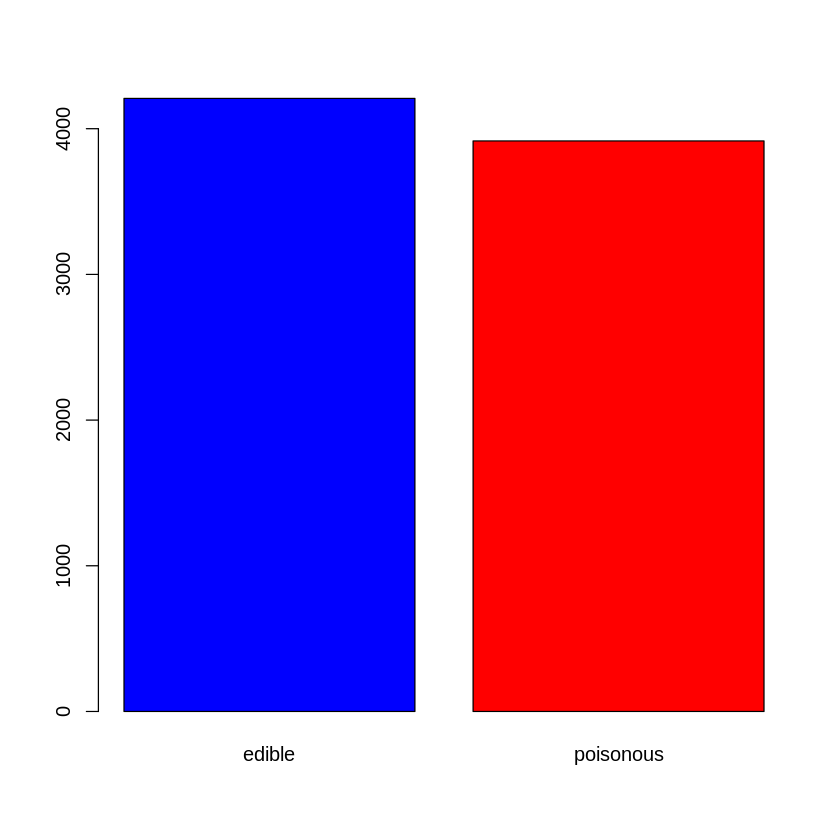

In [7]:
#::GMG::Proporción de clases en el dataset
table(dataset$class)
barplot(height = table(dataset$class),
        col = c('blue','red'),
        names.arg = c('edible','poisonous'))

In [8]:
#::GMG::Dos observaciones
#::nota 1:: 8. Missing Attribute Values: 2480 of them (denoted by "?"), all for
#         attribute #11 (stalk-root)
# en http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
#
summary(dataset$stalk.root)

?    b    c    e    r 
2480 3776  556 1120  192

In [9]:
#::nota 2::veil-type solamente tiene un valor 'p'
#
# veil_type_idx <- which(colnames(dataset) == "veil-type")
# dataset <- dataset[-veil_type_idx]
summary(dataset$veil.type)

p 
8124

In [10]:
#::GMG::Nos cargamos el feature que vale siempre lo mismo y ni aporta
#       nada, nos quedamos con 22 factores
dataset_complete <- dataset
dataset_complete$veil.type <- NULL

In [11]:
#::GMG::Anotamos de forma apropiada los missing values
dataset_complete$stalk.root[dataset_complete$stalk.root == '?'] <- NA
#::GMG::Me deshago el level '?' en stalk_root
# https://www.rdocumentation.org/packages/base/versions/3.5.1/topics/droplevels
dataset_complete$stalk.root<-droplevels(dataset_complete$stalk.root)
summary(dataset_complete$stalk.root)

b    c    e    r NA's 
3776  556 1120  192 2480

In [12]:
str(dataset_complete)

'data.frame':	8124 obs. of  22 variables:
 $ class                   : Factor w/ 2 levels "e","p": 2 1 1 2 1 1 1 1 2 1 ...
 $ cap.shape               : Factor w/ 6 levels "b","c","f","k",..: 6 6 1 6 6 6 1 1 6 1 ...
 $ cap.surface             : Factor w/ 4 levels "f","g","s","y": 3 3 3 4 3 4 3 4 4 3 ...
 $ cap.color               : Factor w/ 10 levels "b","c","e","g",..: 5 10 9 9 4 10 9 9 9 10 ...
 $ bruises                 : Factor w/ 2 levels "f","t": 2 2 2 2 1 2 2 2 2 2 ...
 $ odor                    : Factor w/ 9 levels "a","c","f","l",..: 7 1 4 7 6 1 1 4 7 1 ...
 $ gill.attachment         : Factor w/ 2 levels "a","f": 2 2 2 2 2 2 2 2 2 2 ...
 $ gill.spacing            : Factor w/ 2 levels "c","w": 1 1 1 1 2 1 1 1 1 1 ...
 $ gill.size               : Factor w/ 2 levels "b","n": 2 1 1 2 1 1 1 1 2 1 ...
 $ gill.color              : Factor w/ 12 levels "b","e","g","h",..: 5 5 6 6 5 6 3 6 8 3 ...
 $ stalk.shape             : Factor w/ 2 levels "e","t": 1 1 1 1 2 1 1 1 1 1 ...
 $ stalk.r

### Missing Values

**::GMG::** Hay que decidir qué hacer con la característica (*feature*) `stalk-root` que tiene un 31% de los niveles `NA`. Hay dos caminos que puedo seguir:

1. Eliminar la feature
2. Usar un mecanismo de imputación

Elijo el camino 1 siendo consciente de que la eliminación de esta *feature* no es como el caso de `veil-type` y elimino una fuente de información para la clasificación.

In [13]:
dataset_complete$stalk.root <- NULL

In [14]:
#::GMG::Ya tenemos el dataset que vamos a usar
str(dataset_complete)

'data.frame':	8124 obs. of  21 variables:
 $ class                   : Factor w/ 2 levels "e","p": 2 1 1 2 1 1 1 1 2 1 ...
 $ cap.shape               : Factor w/ 6 levels "b","c","f","k",..: 6 6 1 6 6 6 1 1 6 1 ...
 $ cap.surface             : Factor w/ 4 levels "f","g","s","y": 3 3 3 4 3 4 3 4 4 3 ...
 $ cap.color               : Factor w/ 10 levels "b","c","e","g",..: 5 10 9 9 4 10 9 9 9 10 ...
 $ bruises                 : Factor w/ 2 levels "f","t": 2 2 2 2 1 2 2 2 2 2 ...
 $ odor                    : Factor w/ 9 levels "a","c","f","l",..: 7 1 4 7 6 1 1 4 7 1 ...
 $ gill.attachment         : Factor w/ 2 levels "a","f": 2 2 2 2 2 2 2 2 2 2 ...
 $ gill.spacing            : Factor w/ 2 levels "c","w": 1 1 1 1 2 1 1 1 1 1 ...
 $ gill.size               : Factor w/ 2 levels "b","n": 2 1 1 2 1 1 1 1 2 1 ...
 $ gill.color              : Factor w/ 12 levels "b","e","g","h",..: 5 5 6 6 5 6 3 6 8 3 ...
 $ stalk.shape             : Factor w/ 2 levels "e","t": 1 1 1 1 2 1 1 1 1 1 ...
 $ stalk.s

In [15]:
#::GMG::Balance de clases en el dataset
table(dataset_complete$class)


   e    p 
4208 3916 

## A. Reglas de Asociación

### Punto 1 (3 puntos):

Considerar uno de los algoritmos de asociación vistos en clase y obtener las reglas representativas del dataset fijando los parámetros de aprendizaje (soporte, confianza, etc...). 

### Previo

[Hashler et al. arulesViz](https://cran.r-project.org/web/packages/arulesViz/vignettes/arulesViz.pdf) pp.3

> Before we start, we set the number of displayed significant digits to two to make the output
> easier to read, and we set the seed for the random number generator for predictability.

In [17]:
options(digits = 2)
set.seed(1234)

### Bibliotecas 

In [18]:
library("arules")

Loading required package: Matrix

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write



In [19]:
library("arulesViz")

Loading required package: grid


### Transacciones

In [20]:
#::GMG::Creamos las transacciones de base "desmenuzando" las "features" en "items"
#       con los niveles de sus factores
transactions.ms <- as(dataset_complete, 'transactions')
transactions.ms

transactions in sparse format with
 8124 transactions (rows) and
 113 items (columns)

In [21]:
summary(transactions.ms)

transactions as itemMatrix in sparse format with
 8124 rows (elements/itemsets/transactions) and
 113 columns (items) and a density of 0.19 

most frequent items:
     veil.color=w gill.attachment=f     ring.number=o    gill.spacing=c 
             7924              7914              7488              6812 
      gill.size=b           (Other) 
             5612            134854 

element (itemset/transaction) length distribution:
sizes
  21 
8124 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     21      21      21      21      21      21 

includes extended item information - examples:
       labels variables levels
1     class=e     class      e
2     class=p     class      p
3 cap.shape=b cap.shape      b

includes extended transaction information - examples:
  transactionID
1             1
2             2
3             3

### Apriori

**::GMG::** Elijo como algoritmo de clasificación: `A Priori`

https://www.rdocumentation.org/packages/arules/versions/1.6-2/topics/apriori

#### Generación de reglas ciega

**::GMG::** Genero las reglas de manera *ciega* asociando los items de las transacciones sin tener en cuenta
que es lo que va a RHS.

**::nota::** el guión de la práctica lo establece así para poder seleccionar posteriormente las reglas que
cumplan los criterios de tener en el RHS 'class=p' o 'class=e' a fin de conseguir un modelo para la clasificación
de setas venenosas o comestibles.

In [76]:
rules.ap <- apriori(data = transactions.ms, 
                    parameter=list(support = 0.1, confidence = 0.8,
                                   minlen = 2, maxlen = 10)
                   )

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5     0.1      2
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 812 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[113 item(s), 8124 transaction(s)] done [0.03s].
sorting and recoding items ... [52 item(s)] done [0.00s].
creating transaction tree ... done [0.02s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10

Warning message in apriori(data = transactions.ms, parameter = list(support = 0.1, :
“Mining stopped (maxlen reached). Only patterns up to a length of 10 returned!”

 done [3.20s].
writing ... [814302 rule(s)] done [0.76s].
creating S4 object  ... done [0.40s].


#### Análisis General

Analizar los resultados en términos generales:

* ¿Cuantas reglas se han generado?

In [77]:
rules.ap

set of 814302 rules 

In [78]:
summary(rules.ap)

set of 814302 rules

rule length distribution (lhs + rhs):sizes
     2      3      4      5      6      7      8      9     10 
   273   3876  21287  64800 128639 181316 188153 144604  81354 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     6.0     8.0     7.5     9.0    10.0 

summary of quality measures:
    support       confidence        lift         count     
 Min.   :0.10   Min.   :0.80   Min.   :0.8   Min.   : 814  
 1st Qu.:0.11   1st Qu.:1.00   1st Qu.:1.1   1st Qu.: 864  
 Median :0.11   Median :1.00   Median :1.7   Median : 864  
 Mean   :0.12   Mean   :0.99   Mean   :1.9   Mean   :1010  
 3rd Qu.:0.12   3rd Qu.:1.00   3rd Qu.:2.1   3rd Qu.: 952  
 Max.   :0.97   Max.   :1.00   Max.   :6.3   Max.   :7906  

mining info:
            data ntransactions support confidence
 transactions.ms          8124     0.1        0.8

In [91]:
inspect(head(x = rules.ap,n = 5))

    lhs              rhs                        support confidence lift count
[1] {habitat=l}   => {bruises=f}                0.10    0.99       1.69  824 
[2] {habitat=l}   => {ring.number=o}            0.10    1.00       1.08  832 
[3] {cap.color=w} => {stalk.color.below.ring=w} 0.13    1.00       1.85 1040 
[4] {cap.color=w} => {stalk.color.above.ring=w} 0.13    1.00       1.82 1040 
[5] {cap.color=w} => {ring.number=o}            0.11    0.84       0.91  872 


* ¿Existe alguna regla redundante?, ¿Cuántas?

In [80]:
#::GMG::Según el ejercicio S04_Association_Rules hecho en clase
length(rules.ap[is.redundant(rules.ap)])

[1] 806875

In [81]:
#::GMG::Filtramos las redundantes
rules.ap.filtered <- rules.ap[!is.redundant(rules.ap)]

In [82]:
length(rules.ap.filtered)

[1] 7427

In [83]:
summary(rules.ap.filtered)

set of 7427 rules

rule length distribution (lhs + rhs):sizes
   2    3    4    5    6    7    8 
 273 1397 2687 1978  807  245   40 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     4.0     4.0     4.3     5.0     8.0 

summary of quality measures:
    support       confidence        lift         count     
 Min.   :0.10   Min.   :0.80   Min.   :0.9   Min.   : 816  
 1st Qu.:0.11   1st Qu.:0.88   1st Qu.:1.5   1st Qu.: 864  
 Median :0.13   Median :0.95   Median :1.9   Median :1052  
 Mean   :0.16   Mean   :0.93   Mean   :2.1   Mean   :1306  
 3rd Qu.:0.20   3rd Qu.:1.00   3rd Qu.:2.3   3rd Qu.:1648  
 Max.   :0.97   Max.   :1.00   Max.   :6.3   Max.   :7906  

mining info:
            data ntransactions support confidence
 transactions.ms          8124     0.1        0.8

* ¿Existe alguna regla que incluya la variable objetivo: `Class=edible` ó `Class=poisonous`?, ¿Cuantas?

In [85]:
#::GMG::Para eso hay que usar inspect()/length() + subset()
#:: nota::entiendo que 'incluya' no especifica RHS o LHS así que obtengo ambos casos
length(subset(rules.ap.filtered, 
              subset = (rhs %in% c('class=e') | lhs %in% c('class=e')) |
                       (rhs %in% c('class=p') | lhs %in% c('class=p'))
             )
      )

[1] 2422

* De cara a ser utilizada como modelo predictivo es adecuado que la variable objetivo se encuentre en el consecuente de la regla de asociación, ¿se da esta propiedad en alguna regla?

In [86]:
#::GMG::Queremos que class se encuentre en rhs, claro :)
rules.ap.class <- subset(rules.ap.filtered, 
                         subset = rhs %in% c('class=e') | rhs %in% c('class=p'))

In [87]:
#::GMG::En total
length(rules.ap.class)

[1] 522

In [90]:
summary(rules.ap.class)

set of 522 rules

rule length distribution (lhs + rhs):sizes
  2   3   4   5   6 
 14 145 232 106  25 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     3.0     4.0     4.0     4.8     6.0 

summary of quality measures:
    support       confidence        lift          count     
 Min.   :0.10   Min.   :0.80   Min.   :1.54   Min.   : 816  
 1st Qu.:0.11   1st Qu.:0.90   1st Qu.:1.80   1st Qu.: 912  
 Median :0.14   Median :0.97   Median :1.93   Median :1132  
 Mean   :0.17   Mean   :0.95   Mean   :1.89   Mean   :1374  
 3rd Qu.:0.21   3rd Qu.:1.00   3rd Qu.:2.00   3rd Qu.:1728  
 Max.   :0.42   Max.   :1.00   Max.   :2.07   Max.   :3408  

mining info:
            data ntransactions support confidence
 transactions.ms          8124     0.1        0.8

In [92]:
#::GMG::Reglas de comestibles
rules.ap.class.edible <- subset(rules.ap.class, subset = rhs %in% c("class=e")) 
length(rules.ap.class.edible)

[1] 284

In [94]:
summary(rules.ap.class.edible)

set of 284 rules

rule length distribution (lhs + rhs):sizes
  2   3   4   5   6 
  6  79 144  50   5 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     3.0     4.0     3.9     4.0     6.0 

summary of quality measures:
    support       confidence        lift          count     
 Min.   :0.10   Min.   :0.80   Min.   :1.54   Min.   : 816  
 1st Qu.:0.12   1st Qu.:0.89   1st Qu.:1.71   1st Qu.: 960  
 Median :0.15   Median :0.96   Median :1.86   Median :1236  
 Mean   :0.18   Mean   :0.94   Mean   :1.81   Mean   :1461  
 3rd Qu.:0.22   3rd Qu.:1.00   3rd Qu.:1.93   3rd Qu.:1778  
 Max.   :0.42   Max.   :1.00   Max.   :1.93   Max.   :3408  

mining info:
            data ntransactions support confidence
 transactions.ms          8124     0.1        0.8

In [93]:
#::GMG::Reglas de venenosas
rules.ap.class.poisonous <- subset(rules.ap.class, subset = rhs %in% c("class=p"))
length(rules.ap.class.poisonous)

[1] 238

In [95]:
summary(rules.ap.class.poisonous)

set of 238 rules

rule length distribution (lhs + rhs):sizes
 2  3  4  5  6 
 8 66 88 56 20 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     3.0     4.0     4.1     5.0     6.0 

summary of quality measures:
    support       confidence        lift          count     
 Min.   :0.10   Min.   :0.81   Min.   :1.68   Min.   : 824  
 1st Qu.:0.11   1st Qu.:0.93   1st Qu.:1.94   1st Qu.: 880  
 Median :0.12   Median :0.97   Median :2.02   Median :1008  
 Mean   :0.16   Mean   :0.96   Mean   :1.99   Mean   :1269  
 3rd Qu.:0.19   3rd Qu.:1.00   3rd Qu.:2.07   3rd Qu.:1559  
 Max.   :0.39   Max.   :1.00   Max.   :2.07   Max.   :3188  

mining info:
            data ntransactions support confidence
 transactions.ms          8124     0.1        0.8

#### Análisis Detallado

* Considerar los subconjuntos de reglas con ambas clases como consecuente e ilustrar las variables implicadas en cada caso. Considerar alguno de los grafos vistos para apoyar las conclusiones obtenidas.

**::GMG::** ¿Cómo selecciono las reglas?

Después del filtrado que he hecho quedan todavía un número considerable de reglas de ambas clases.

Puedo hacer una selección fijando una métrica de los criterios criterios disponibles (support, confidence, lift),
de manera que salgan unas *pocas* reglas. Supongo que un modelo simple debe tener pocas reglas y deben intervenir
el menor número de características posibles (que serán las que más *peso* tengan en la decisión)

**::DUDAS::** 

- ¿Cómo se forman las reglas del modelo?
- Si selecciono N reglas con (support, confidence, lift), para formar las reglas del modelo,
  ¿las reglas se unen con OR o AND?
- Una vez seleccionadas y formadas las reglas, ¿cómo aplico las reglas para comprobar que funcionan?
- No veo el flujo que va desde el filtrado de las reglas a la obtención de un modelo de predicción

**::nota::** Dudas **no resueltas**.

In [121]:
#::GMG::Puedo generar una selección de reglas con los criterios disponibles
#::nota:: no sé interpretar esa selección como las "reglas del modelo de decisión"
inspect(rules.ap.class[quality(rules.ap.class)$support > 0.21 & 
                       quality(rules.ap.class)$confidence == 1  &
                       quality(rules.ap.class)$lift > 1.95])

     lhs                             rhs       support confidence lift count
[1]  {gill.color=b}               => {class=p}    0.21          1  2.1  1728
[2]  {odor=f}                     => {class=p}    0.27          1  2.1  2160
[3]  {gill.spacing=c,                                                       
      stalk.surface.below.ring=k} => {class=p}    0.27          1  2.1  2160
[4]  {stalk.surface.below.ring=k,                                           
      ring.number=o}              => {class=p}    0.27          1  2.1  2160
[5]  {gill.spacing=c,                                                       
      stalk.surface.above.ring=k} => {class=p}    0.27          1  2.1  2228
[6]  {stalk.surface.above.ring=k,                                           
      ring.number=o}              => {class=p}    0.27          1  2.1  2192
[7]  {stalk.shape=t,                                                        
      spore.print.color=w}        => {class=p}    0.21          1  2.1  1728

#### Análisis gráfico

**::GMG::** De los gráficos de aRulesViz el que me parece más interesante para ver 
las reglas *combinadas* (class=p, class=e) es el *grouped*. Para limitar el número de
reglas a considerar exigo un soporte mayor de 0.3 como criterio adicional de selección

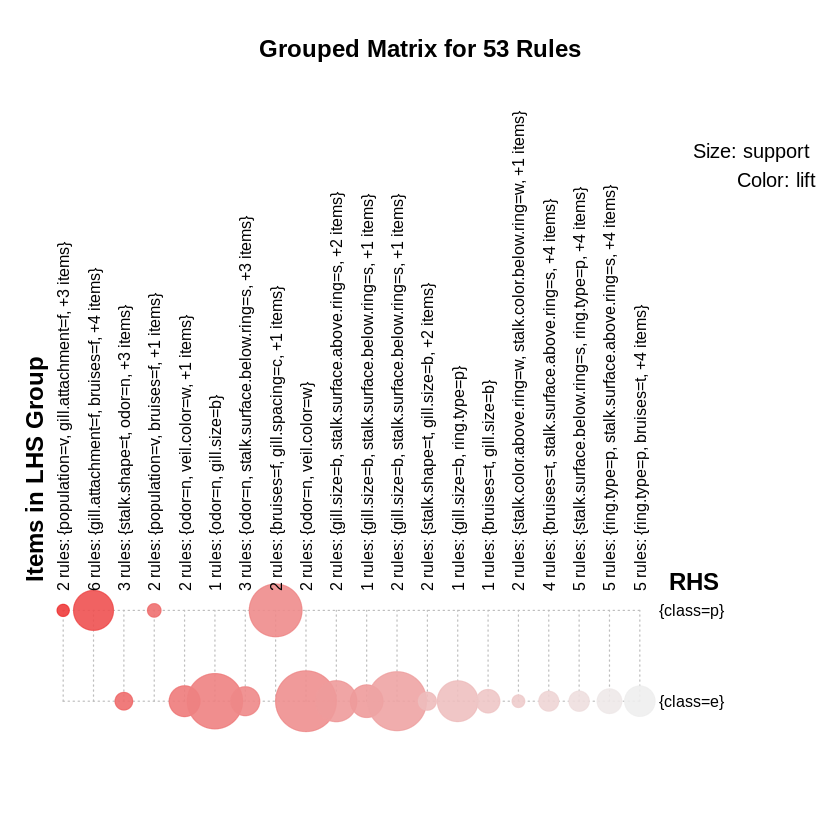

In [98]:
plot(rules.ap.class[quality(rules.ap.class)$support > 0.3], method = "grouped")

**::GMG**:: Si considero las reglas de una de las clases (class=e) y selecciono las 25 con más
lift ...

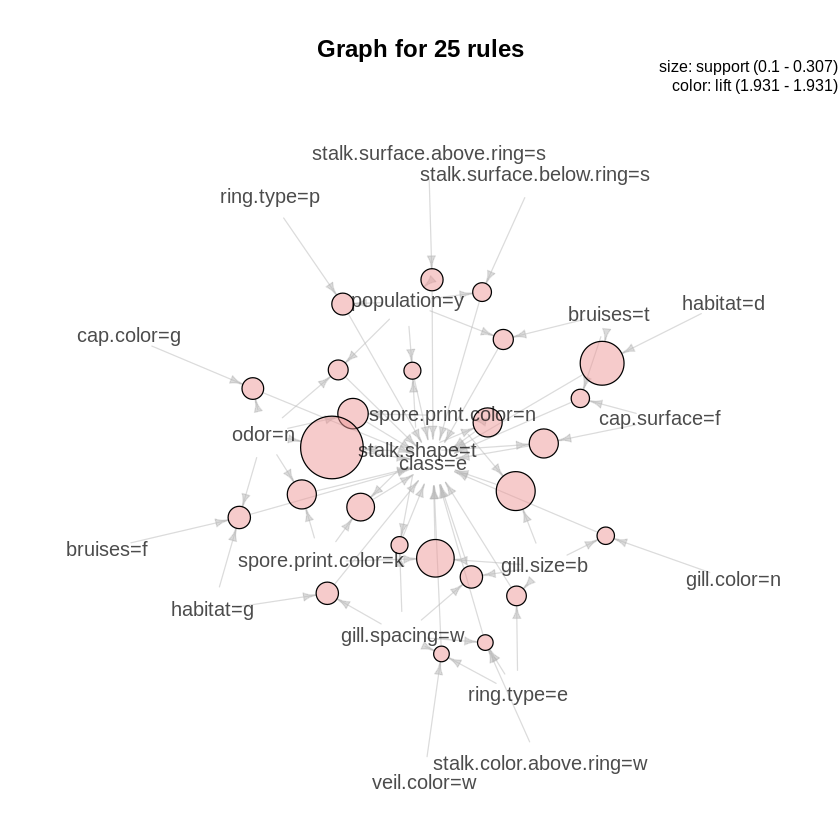

In [111]:
plot(head(rules.ap.class.edible, n = 25, by = 'lift'), method="graph")

#### Generación de reglas 'class'

In [48]:
#::GMG::Puedo generar directamente unas reglas con los consecuentes (RHS) que busco utilizando
#       el parámetro "appearnce" de apriori()
rules.ap <- apriori(data = transactions.ms, 
                    parameter=list(support = 0.01, confidence = 0.8,
                                   minlen = 2, maxlen = 10),
                    appearance=list(rhs = c('class=e','class=p'), default = 'lhs')
                   )

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5    0.01      2
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 81 

set item appearances ...[2 item(s)] done [0.00s].
set transactions ...[113 item(s), 8124 transaction(s)] done [0.01s].
sorting and recoding items ... [90 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 5 6 7

Warning message in apriori(data = transactions.ms, parameter = list(support = 0.01, :
“Mining stopped (time limit reached). Only patterns up to a length of 7 returned!”

 done [12.44s].
writing ... [1407671 rule(s)] done [1.07s].
creating S4 object  ... done [2.88s].


#### Análisis General

Analizar los resultados en términos generales:

* ¿Cuantas reglas se han generado?

In [49]:
rules.ap

set of 1407671 rules 

In [50]:
summary(rules.ap)

set of 1407671 rules

rule length distribution (lhs + rhs):sizes
     2      3      4      5      6      7 
    43   1381  15750  95744 362623 932130 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     6.0     7.0     6.6     7.0     7.0 

summary of quality measures:
    support       confidence        lift          count     
 Min.   :0.01   Min.   :0.80   Min.   :1.54   Min.   :  82  
 1st Qu.:0.01   1st Qu.:1.00   1st Qu.:1.93   1st Qu.: 108  
 Median :0.02   Median :1.00   Median :1.93   Median : 144  
 Mean   :0.03   Mean   :0.99   Mean   :1.98   Mean   : 211  
 3rd Qu.:0.03   3rd Qu.:1.00   3rd Qu.:2.07   3rd Qu.: 216  
 Max.   :0.42   Max.   :1.00   Max.   :2.07   Max.   :3408  

mining info:
            data ntransactions support confidence
 transactions.ms          8124    0.01        0.8

In [51]:
inspect(head(x = rules.ap,n = 25))

     lhs                           rhs       support confidence lift count
[1]  {stalk.color.above.ring=e} => {class=e} 0.012   1.00       1.9   96  
[2]  {gill.color=e}             => {class=e} 0.012   1.00       1.9   96  
[3]  {veil.color=o}             => {class=e} 0.012   1.00       1.9   96  
[4]  {veil.color=n}             => {class=e} 0.012   1.00       1.9   96  
[5]  {stalk.color.below.ring=e} => {class=e} 0.012   1.00       1.9   96  
[6]  {odor=c}                   => {class=p} 0.024   1.00       2.1  192  
[7]  {stalk.color.above.ring=o} => {class=e} 0.024   1.00       1.9  192  
[8]  {stalk.color.below.ring=o} => {class=e} 0.024   1.00       1.9  192  
[9]  {habitat=w}                => {class=e} 0.024   1.00       1.9  192  
[10] {gill.attachment=a}        => {class=e} 0.024   0.91       1.8  192  
[11] {odor=p}                   => {class=p} 0.032   1.00       2.1  256  
[12] {habitat=m}                => {class=e} 0.032   0.88       1.7  256  
[13] {population=c}      

* ¿Existe alguna regla redundante?, ¿Cuántas?

In [52]:
#::GMG::Según el ejercicio S04_Association_Rules hecho en clase
length(rules.ap[is.redundant(rules.ap)])

[1] 1404615

In [53]:
#::GMG::Filtramos las redundantes
rules.ap.filtered <- rules.ap[!is.redundant(rules.ap)]

In [54]:
length(rules.ap.filtered)

[1] 3056

In [55]:
summary(rules.ap.filtered)

set of 3056 rules

rule length distribution (lhs + rhs):sizes
   2    3    4    5    6    7 
  43  597 1247  849  274   46 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     4.0     4.0     4.3     5.0     7.0 

summary of quality measures:
    support       confidence        lift          count     
 Min.   :0.01   Min.   :0.80   Min.   :1.54   Min.   :  82  
 1st Qu.:0.02   1st Qu.:0.91   1st Qu.:1.81   1st Qu.: 144  
 Median :0.04   Median :0.98   Median :1.93   Median : 288  
 Mean   :0.06   Mean   :0.95   Mean   :1.90   Mean   : 469  
 3rd Qu.:0.07   3rd Qu.:1.00   3rd Qu.:2.02   3rd Qu.: 576  
 Max.   :0.42   Max.   :1.00   Max.   :2.07   Max.   :3408  

mining info:
            data ntransactions support confidence
 transactions.ms          8124    0.01        0.8

#### Análisis Detallado

* Considerar los subconjuntos de reglas con ambas clases como consecuente e ilustrar las variables implicadas en cada caso. Considerar alguno de los grafos vistos para apoyar las conclusiones obtenidas.

In [63]:
#::GMG::Ejemplo de las reglas de comestibles con más "lift"
rules.ap.class.edible <- subset(rules.ap.class, subset = rhs %in% c("class=e")) 

In [64]:
inspect(head(x = rules.ap.class.edible, n = 25, by ="lift"))

     lhs                             rhs       support confidence lift count
[1]  {stalk.color.above.ring=e}   => {class=e}   0.012          1  1.9    96
[2]  {gill.color=e}               => {class=e}   0.012          1  1.9    96
[3]  {veil.color=o}               => {class=e}   0.012          1  1.9    96
[4]  {veil.color=n}               => {class=e}   0.012          1  1.9    96
[5]  {stalk.color.below.ring=e}   => {class=e}   0.012          1  1.9    96
[6]  {stalk.color.above.ring=o}   => {class=e}   0.024          1  1.9   192
[7]  {stalk.color.below.ring=o}   => {class=e}   0.024          1  1.9   192
[8]  {habitat=w}                  => {class=e}   0.024          1  1.9   192
[9]  {population=a}               => {class=e}   0.047          1  1.9   384
[10] {odor=l}                     => {class=e}   0.049          1  1.9   400
[11] {population=n}               => {class=e}   0.049          1  1.9   400
[12] {odor=a}                     => {class=e}   0.049          1  1.9   400

In [65]:
#::GMG::Ejemplo de las reglas de venenosas con más "lift"
rules.ap.class.poisonous <- subset(rules.ap.class, subset = rhs %in% c("class=p"))

In [66]:
inspect(head(x = rules.ap.class.poisonous, n = 25, by ="lift"))

     lhs                           rhs       support confidence lift count
[1]  {odor=c}                   => {class=p}   0.024          1  2.1   192
[2]  {odor=p}                   => {class=p}   0.032          1  2.1   256
[3]  {stalk.color.above.ring=b} => {class=p}   0.053          1  2.1   432
[4]  {stalk.color.below.ring=b} => {class=p}   0.053          1  2.1   432
[5]  {odor=y}                   => {class=p}   0.071          1  2.1   576
[6]  {odor=s}                   => {class=p}   0.071          1  2.1   576
[7]  {ring.type=l}              => {class=p}   0.160          1  2.1  1296
[8]  {gill.color=b}             => {class=p}   0.213          1  2.1  1728
[9]  {odor=f}                   => {class=p}   0.266          1  2.1  2160
[10] {cap.color=b,                                                        
      spore.print.color=h}      => {class=p}   0.012          1  2.1    96
[11] {cap.color=b,                                                        
      ring.type=p}       

In [67]:
inspect(rules.ap.class.poisonous[quality(rules.ap.class.poisonous)$support > 0.3])

     lhs                    rhs       support confidence lift count
[1]  {bruises=f,                                                   
      population=v}      => {class=p}    0.31       0.92  1.9  2504
[2]  {bruises=f,                                                   
      gill.spacing=c}    => {class=p}    0.39       0.90  1.9  3188
[3]  {bruises=f,                                                   
      gill.spacing=c,                                              
      population=v}      => {class=p}    0.30       0.94  1.9  2456
[4]  {bruises=f,                                                   
      gill.attachment=f,                                           
      population=v}      => {class=p}    0.31       0.95  2.0  2504
[5]  {bruises=f,                                                   
      veil.color=w,                                                
      population=v}      => {class=p}    0.31       0.95  2.0  2504
[6]  {bruises=f,                                

#### Análisis gráfico

In [ ]:
#::GMG::Gráficos que se pueden usar ... estos no me han sacado de nada
#plot(rules.ap.filtered, measure = c("support", "lift"), shading = "confidence")
#plot(rules.ap.filtered, method = "two-key plot", jitter = 0)
#plot(rules.ap.filtered[quality(rules.ap.filtered)$support > 0.3], method = 'paracoord',
#     control = list(reorder = TRUE))
#plot(rules.ap.filtered[quality(rules.ap.filtered)$support > 0.3], method = 'paracoord',
#     control = list(reorder = TRUE))
#plot(rules.ap.filtered[quality(rules.ap.filtered)$support > 0.3], method="graph")

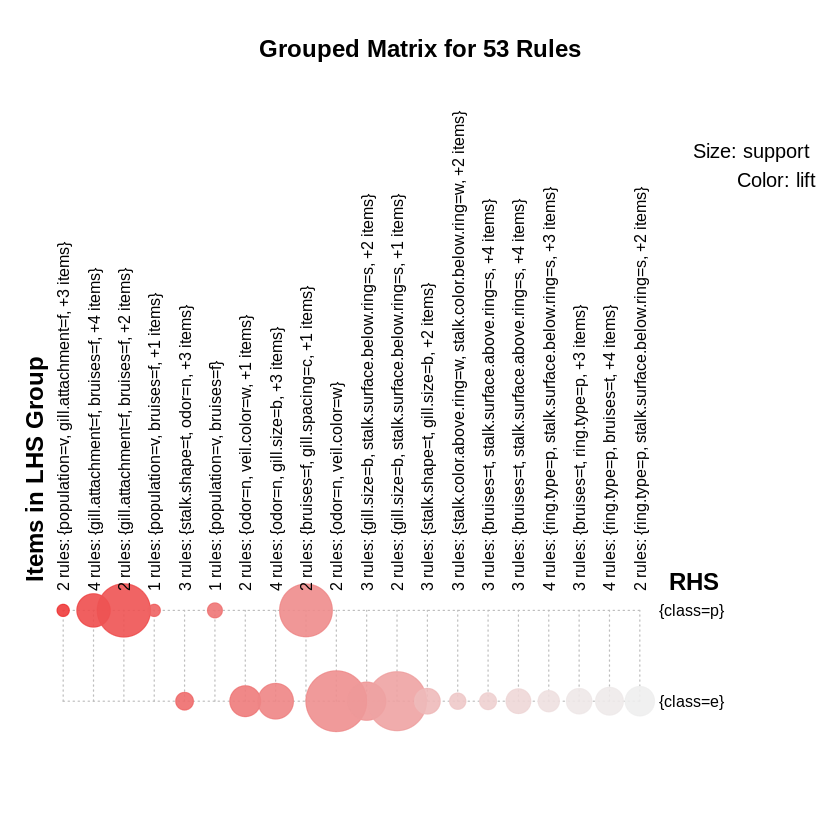

In [70]:
plot(rules.ap.filtered[quality(rules.ap.filtered)$support > 0.3], method = "grouped")

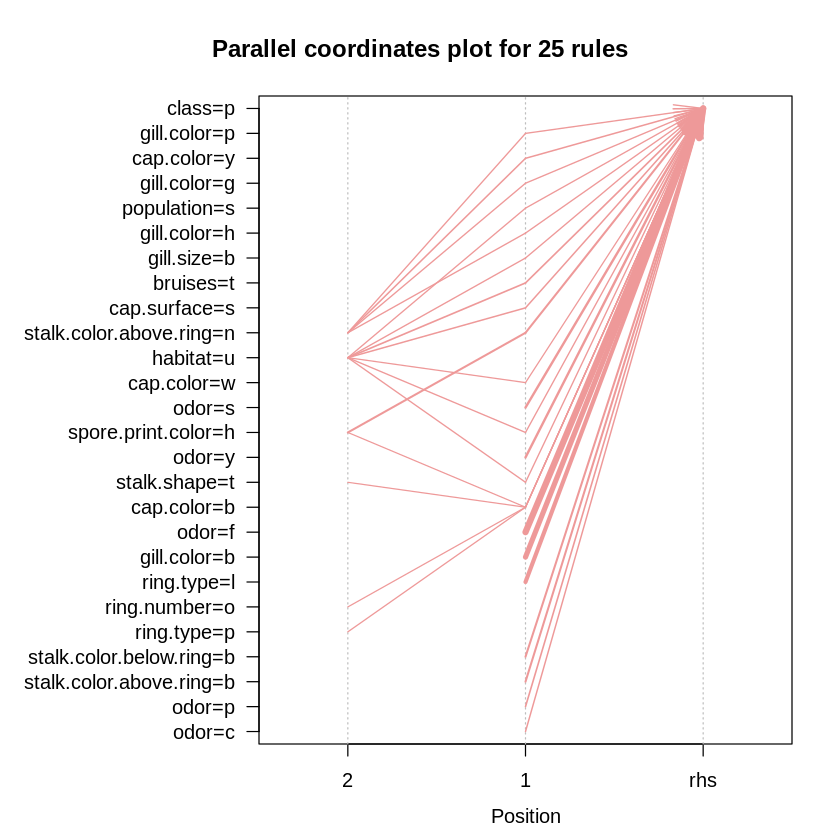

In [71]:
plot(head(rules.ap.class.poisonous, n = 25, by ='lift'), method = 'paracoord',
     control = list(reorder = TRUE))

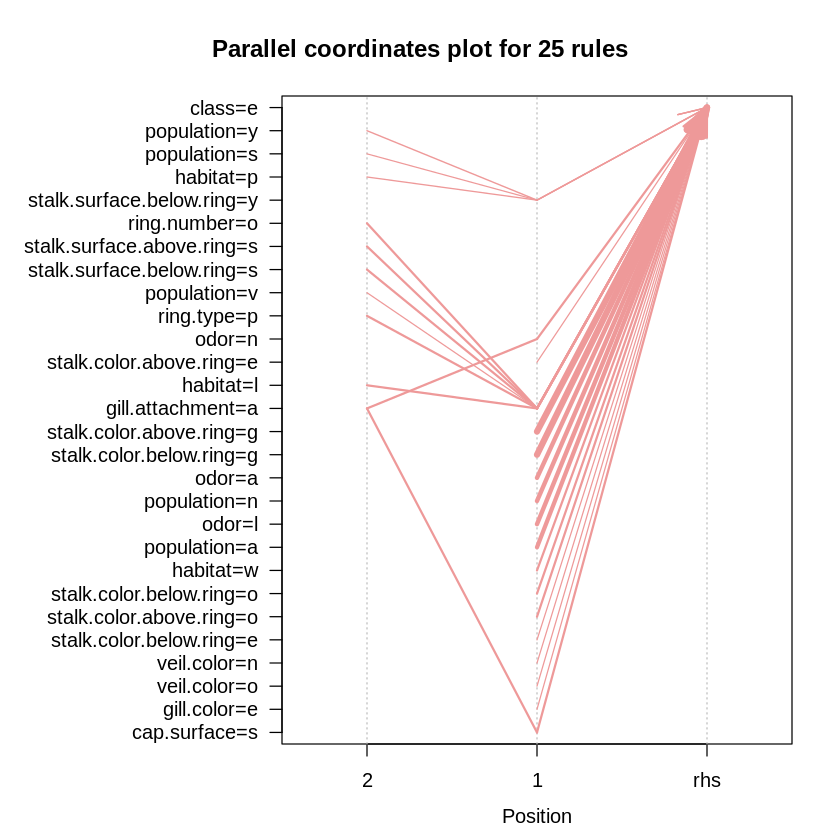

In [73]:
plot(head(rules.ap.class.edible, n = 25, by ='lift'), method = 'paracoord',
     control = list(reorder = TRUE))

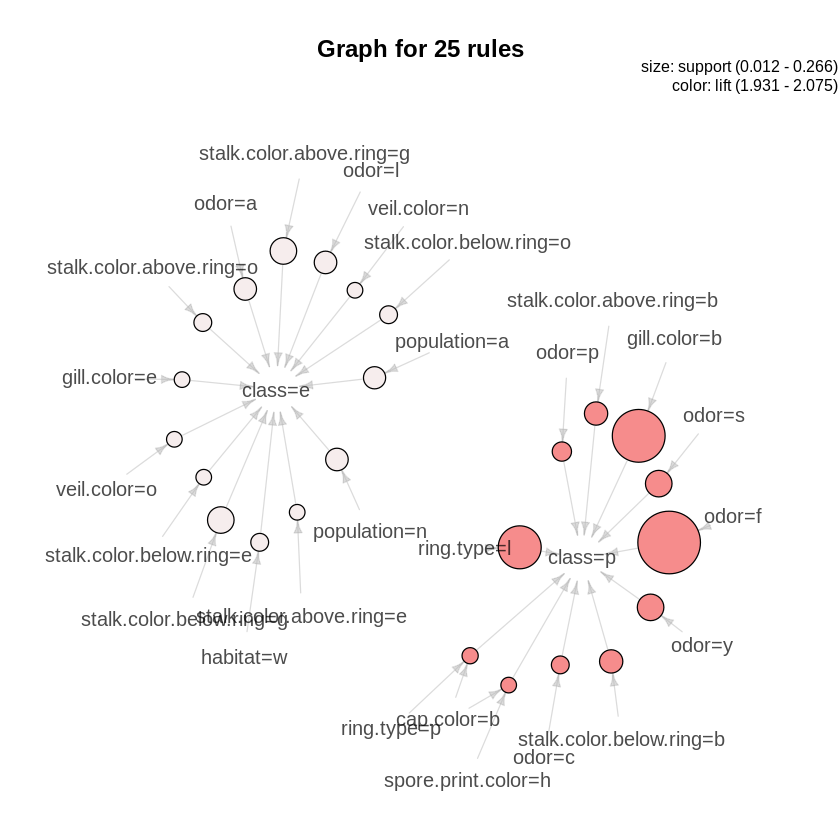

In [72]:
plot(head(rules.ap.filtered, n = 25, by = 'confidence'), method="graph")

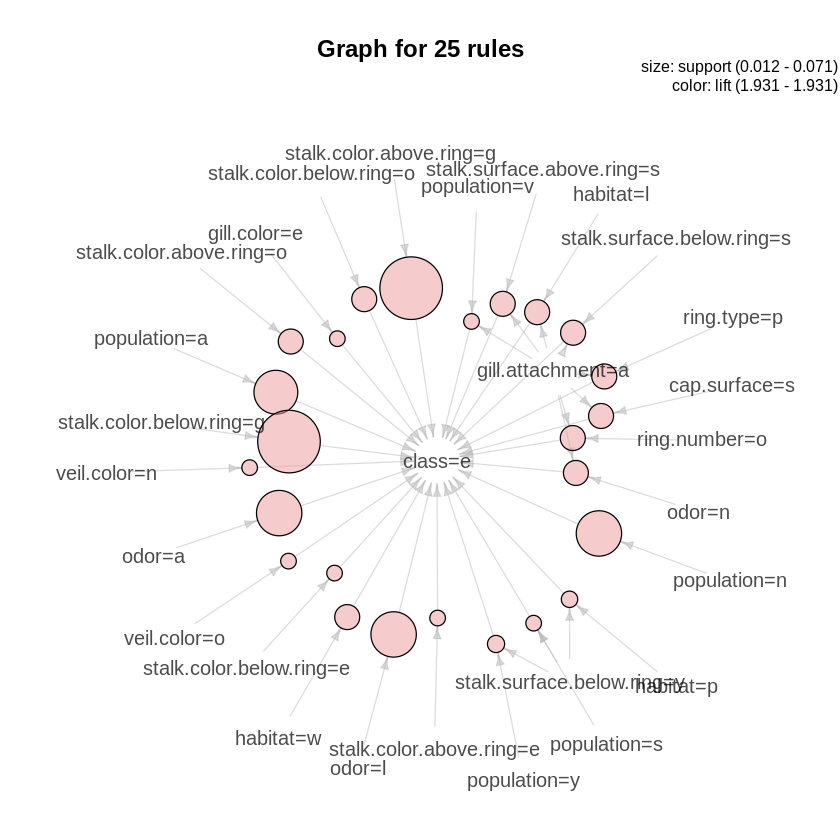

In [75]:
plot(head(rules.ap.class.edible, n = 25, by = 'lift'), method="graph")

## B. Árboles de Decisión

### Punto 2 (4 puntos):

#### Bibliotecas

In [ ]:
library(caret)
library(tree)
library(rpart)
library(rpart.plot)

#### Dataset

En este apartado aplicaremos árboles de clasificación para obtener un modelo que permita clasificar una nueva entrada. Para ello, vamos a utilizaremos el paquete `CaReT`. Este paquete (y los demás que hemos visto para trabajar con árboles en `R`) no aceptan objetos del tipo `transactions` como los del apartado anterior. Por tanto, hemos preparado un fichero *csv* con el dataset *Mushrooms*; puedes descargarlo desde esta aquí:
https://github.com/SantanderMetGroup/Master-Data-Science/tree/master/Data_mining/datasets. Lee el dataset con la función `read.csv`.

**::GMG::** Yo utilizo el dataset preparado en mi **::GMG::Punto 0**.

In [ ]:
str(dataset_complete)

In [ ]:
table(dataset_complete$class)

In [ ]:
#summary(dataset_complete)

>Ahora ya tenemos un data.frame con el que podemos empezar a trabajar. En primer lugar tendremos que eliminar la columna 17 (`veil.type`), ya que contiene un único nivel y daría errores en `CaReT`(esta columna podría eliminarse también en el caso de las reglas de asociación ya que no aporta información al dataset). 

**::GMG::** Esto ya lo he tenido en cuenta en mi dataset (ver *::GMG::Punto 0**)

#### Rpart Train

Nuestro objetivo será *encontrar la configuración (profundidad) óptima del árbol*. 

Para ello, partiremos el dataset en dos subconjuntos indpendedientes de train y test (75% y 25% del total, respectivamente). 

In [ ]:
#::GMG::Hago la patición train/test del dataset tal y como nos indican
#       En clase vimos una partición basada en el uso de índices con sample()
set.seed(666) # Fijo un seed diabólico :)
#n <- nrow(dataset_complete)
#indtrain <- sample(1:n, 0.75 * n)
#indtest <- setdiff(1:n, indtrain)
#dataset.train <- dataset_complete[indtrain,]
#dataset.test <- dataset_complete[indtest,]
#::GMG::Una alternativa "lazy" ya que estamos usando "caret" es usar la función
#       createDataPartition para el train/test
# https://www.rdocumentation.org/packages/caret/versions/6.0-81/topics/createDataPartition
trainidx <- createDataPartition(dataset_complete$class, p=0.75, list=FALSE)
#::nota::el dataset de entrenamiento será el compuesto por los índices seleccionados
dataset.train <- dataset_complete[trainidx,]
#::nota: la parte de test será "el resto"
dataset.test <- dataset_complete[-trainidx,]

Sobre el dataset de train, aplicaremos una cross-validación con 3 folds y la repetiremos 50 veces (recuerda que los árboles son sensibles a la partición train/test que se considere). 

In [ ]:
#::GMG::Aplico el entrenamiento descrito con 3-fold cross-validation, 50 veces
#       Primero tengo que fijar el "procedimiento de entrenamiento" de Caret
#       'number'-folds, 'repeats' times
mi.trControl <- trainControl(method = "repeatedcv",  number=3, repeats=50, verboseIter=FALSE)

In [ ]:
#::GMG::Hago el entrenamiento
modelo.rpart <- train(class ~ ., 
                      data = dataset.train,
                      method = "rpart2",
                      trControl = mi.trControl,
                      tuneGrid = expand.grid(maxdepth = 1:10),
                      metric = 'Accuracy')

In [ ]:
#::GMG::Echo un vistazo a lo que se ha obtenido
#::nota::una profundidad óptima de 6 según la métrica "Accuracy"
modelo.rpart

In [ ]:
#::Más cosas que se pueden ver
# https://www.statmethods.net/advstats/cart.html
summary(modelo.rpart$results)

In [ ]:
#::GMG::Las variables tenidas en cuenta
# https://www.rdocumentation.org/packages/caret/versions/6.0-81/topics/varImp
#::nota::la visualización no es muy buena porque mezcla el nombre
#        de la variable y su valor, hay que tirar de la descripción en
# https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
#        para aclararse :)
varImp(modelo.rpart)

In [ ]:
#::GMG::El modelo final de árbol obtenido, "dibujado" más o menos :)
rpart.plot(modelo.rpart$finalModel, type = 5,cex=0.6)

**::DUDA::** ¿Cómo se interpreta ese modelo en "reglas"?

Se necesita la siguiente información de la [descripción del dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names):

<pre>7. Attribute Information: (classes: edible=e, poisonous=p)
     1. cap-shape:                bell=b,conical=c,convex=x,flat=f,
                                  knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r,
                                  pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f,
                                  musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g,
                                  green=r,orange=o,pink=p,purple=u,red=e,
                                  white=w,yellow=y
    10. stalk-shape:              enlarging=e,tapering=t
    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e,
                                  rhizomorphs=z,rooted=r,missing=?
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
    14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    16. veil-type:                partial=p,universal=u
    17. veil-color:               brown=n,orange=o,white=w,yellow=y
    18. ring-number:              none=n,one=o,two=t
    19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l,
                                  none=n,pendant=p,sheathing=s,zone=z
    20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r,
                                  orange=o,purple=u,white=w,yellow=y
    21. population:               abundant=a,clustered=c,numerous=n,
                                  scattered=s,several=v,solitary=y
    22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p,
                                  urban=u,waste=w,woods=d</pre>

De izquierda a derecha, de arriba a abajo del árbol:

1. reglas para "edible":
 - R_1 := odor=none.AND.spore-print-color=NOT.green
 - R_2 := odor=NOT.none.AND.bruises=TRUE.AND.odor=NOT.foul.AND.odor=NOT.pungent
 
2. reglas para "poisonous":
 - R_1 :=  ...

**::nota::** duda **no resuelta**

#### Rpart Test

In [ ]:
#::GMG::Pruebo el modelo en el conjunto reservado para test final y
#       visualizo el resultado con confusionMatrix() de caret
# https://www.rdocumentation.org/packages/caret/versions/6.0-81/topics/confusionMatrix
modelo.rpart.test <- predict(modelo.rpart, dataset.test)
confusionMatrix(modelo.rpart.test, dataset.test$class)

**::GMG::** Cometemos un error *importante* de tipo *falso positivo*, i.e hay 12 casos que se han predicho *edible* cuando son **poisonous**. Es un _error *Type I*_ que en nuestro dataset es **mortal**. Es más importante tener aquí un *cero* que tenerlo en el otro valor de la diagonal (*falso negativo*). 

**::DUDA::** ¿Qué se puede hacer para asegurar un cero en FP?

**::nota::** Duda **no resuelta**

#### Análisis

* ¿Cuál es la configuración óptima del árbol? ¿Hay alguna diferencia entre el árbol *completo* y el óptimo? ¿Por qué crees que ocurre esto?
* ¿Cuáles son las dos variables que mayor peso tienen a la hora de clasificar? Entrena un nuevo árbol considerando como predictores únicamente esas dos variables. ¿Qué resultados obtienes? 
* Entrena un nuevo árbol considerando como predictores cualesquiera otras dos variables que no sean las utilizadas en la pregunta anterior. ¿Cuál es el error de test de este árbol?

### Punto 3 (3 puntos):

Por un lado, las ramas del árbol pueden ser interpretadas como reglas de forma similar a las obtenidas por el algoritmo de reglas aplicado. Por ejemplo, en el caso del árbol obtenido con el dataset `Play Tennis` puede obtenerse las siguientes `reglas`: SI Outlook = Overcast -> Play Tennis = Yes ó SI (Outlook = Sunny) AND (Humidity = Normal) -> Play Tennis = Yes, cuya confianza asociada viene dada por la frecuencia relativa de cada caso en esa rama del árbol. Por otro lado, considerando las reglas que implican a nuestra variable objetivo tendríamos un `modelo` similar al dado por el árbol. Considerar y comparar ambas aproximaciones (p.e. ¿coinciden los antecedentes de las reglas? ¿alguna de las variables más frecuentes como antecedente en las reglas se corresponde con alguna de las variables con mayor capacidad de discriminación? etc.). 

**::GMG::** Este apartado le dejo *sin hacer*.

**::nota::** En algún momento me gustaría tener la solución para poder aprender de ella.